In [1]:
import numpy as np
from matplotlib import pyplot as plt

Define the problem parameters


In [2]:
A = np.array([[1, 3], [3, 1]]) # low dimensions to plot it, you can test larger sizes
b = np.array([-1, 2])

lmbda = 0.5


The function to be minimized is $\frac{1}{2}\|Ax-b\|_2^2 + \lambda \|x\|_1$

In [3]:
f = lambda x: 0.5 * np.sum((A @ x - b) ** 2)
F = lambda x: f(x) + lmbda * np.sum(np.abs(x))

# derivative of f from matrix calculus
df = lambda x: A.T @ (A @ x) - A.T @ b


Plot the function

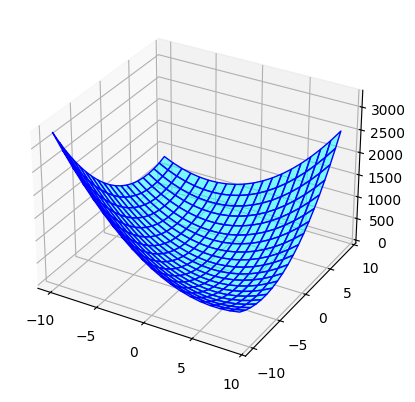

In [4]:
# this function has been prepared only for the visualization sake, no need to go through this but it renders some nice
# graphics :)
Fplot = lambda r1, r2: (r1 * A[0, 0] + r2 * A[0, 1] - b[0]) ** 2 + (r1 * A[1, 0] + r2 * A[1,1] - b[1]) ** 2 + lmbda * (np.abs(r1) + np.abs(r2))
xx, yy = np.meshgrid(np.arange(-10, 10, 1), np.arange(-10, 10, 1))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, Fplot(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])

ISTA with backtracking
----------------------------
Parameters of ISTA

In [5]:
MAX_ITER = 1e3
TOL_DIST_X = 1e-6
# initial value for alpha
alpha = 1
# parameter for backtracking
eta = 0.99

Initialization: test different inizializations, the function is convex, you always converge to the same solution

In [6]:
x = np.array([-5, 10])

grad_norm = 1e10
distanceX = 1e10

# initialize the list with all the estimates
all_x = [x]
x_past = x

Useful function for computing Soft Thresholding

In [7]:
def soft_thresholding(x, lmbda, method="original"):
    if method == "original":
        for i in range(len(x)):
            if x[i] > lmbda:
                x[i] = x[i] - lmbda
            elif x[i] < -lmbda:
                x[i] = x[i] + lmbda
            else:
                x[i] = 0
    elif method == "fast":
        x = np.sign(x) * np.maximum(np.abs(x) - lmbda, 0)
    else:
        raise ValueError("Invalid method. Choose 'original' or 'new'.")
    return x

Main loop

In [8]:
cnt = 0
alpha_current = alpha
while cnt < MAX_ITER and distanceX > TOL_DIST_X:

    # compute the argument of the proximal operator
    x_current = x_past - alpha_current * df(x_past)

    # perform soft thresholding of x
    x_current = soft_thresholding(x_current, alpha_current*lmbda, 'fast') # NOTE about alpha_current*lmbda
    '''
    If only alpha_current is passed, it likely represents the raw step size or dynamic weight adjustment.
    Using just this doesn't make much sense unless it has been derived to act as a threshold directly.
    If alpha_current * lmbda is passed, the product scales the regularization term lmbda appropriately for the iteration.
    '''

    # iterate the backtracking procedure until the stopping criterion is met
    while f(x_current) > f(x_past) + np.dot(df(x_past).T, (x_current - x_past)) + (1/(2 * alpha_current) * np.linalg.norm(x_current - x_past) ** 2):
      # update alpha
      alpha_current = eta * alpha_current

      # compute again x
      x_current = x_past - alpha_current * df(x_past)

      # perform soft thresholding of x
      x_current = soft_thresholding(x_current, alpha_current*lmbda, 'fast')

    # compute the stopping criteria
    distanceX = np.linalg.norm(x_current - x_past)

    # store the estimate
    all_x.append(x_current)
    x_past = x_current
    cnt = cnt + 1

Plot all the estimates

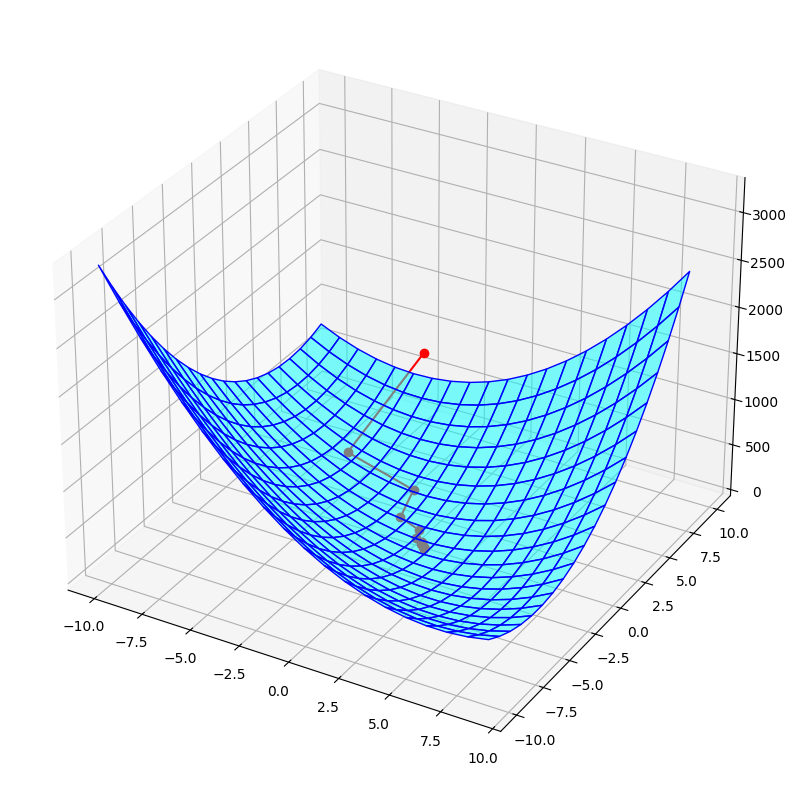

In [9]:
# plot the new estimate
xxplot = [x[0] for x in all_x]
yyplot = [x[1] for x in all_x]
zzplot = Fplot(np.array(xxplot), np.array(yyplot))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, Fplot(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])
ax.plot3D(xxplot, yyplot, zzplot, 'r-o')

Compare the number of iteration needed for convergence with backtracking with the number of iteration required using the optimal alpha

In [10]:
print(f'nr of iteration of ISTA with backtracking (before stopping criteria met): {cnt}\n')
print(f'Solution of ISTA: [{x_current[0]:.4f}, {x_current[1]:.4f}]\n')
print(f'Value of the functional: {F(x_current):.4f}\n')

nr of iteration of ISTA with backtracking (before stopping criteria met): 34

Solution of ISTA: [0.7500, -0.5000]

Value of the functional: 0.6875



FISTA
-----
Parameters of FISTA

In [11]:
MAX_ITER = 1e3
TOL_DIST_X = 1e-6
# set the optimal value for alpha
alpha = 1
alpha_past = alpha

Initialization: test different inizializations, the function is convex, you always converge to the same solution

In [12]:
# initialize x
x = np.array([-5, 10])

# initialize y
y = np.array([-5, 10])

# compute the Lipschitz constant
L = np.max(np.linalg.eigvals(np.matmul(A.T, A)))
# initialize gamma
gamma = 1/L

grad_norm = 1e10
distanceX = 1e10

# initialize the list with all the estimates
all_x = [x]
x_past = x

Main loop

In [13]:
cnt = 0
while cnt < MAX_ITER and distanceX > TOL_DIST_X:
    # compute the argument of the proximal operator
    x_current = y - gamma * df(y)

    # perform soft thresholding of x
    x_current = soft_thresholding(x_current, gamma*lmbda, 'fast')

    # update gamma
    alpha_current = (1 + np.sqrt(1 + 4 * alpha_past ** 2)) / 2

    # update y
    y = x_current + ((alpha_past - 1)/alpha_current) * (x_current - x_past)

    # compute the stopping criteria
    distanceX = np.linalg.norm(x_current - x_past)

    # update the counter
    cnt = cnt + 1

    # store the estimate
    all_x.append(x_current)
    x_past = x_current
    alpha_past = alpha_current

Plot all the estimates

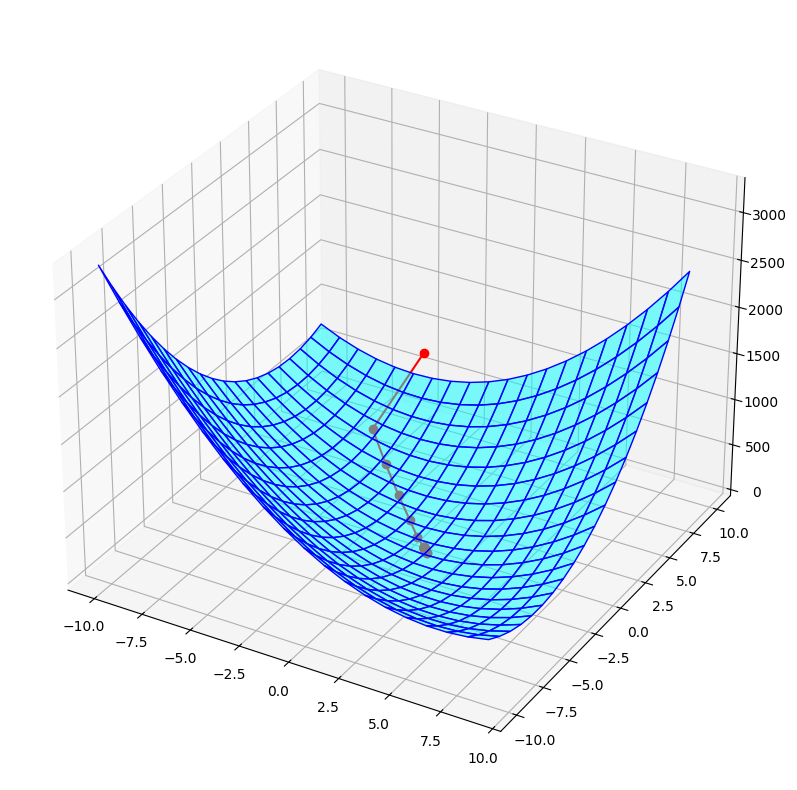

In [14]:
# plot the new estimate
xxplot = [x[0] for x in all_x]
yyplot = [x[1] for x in all_x]
zzplot = Fplot(np.array(xxplot), np.array(yyplot))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, Fplot(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])
ax.plot3D(xxplot, yyplot, zzplot, 'r-o')

In [15]:
print(f'nr of iteration of FISTA (before stopping criteria met): {cnt}\n')
print(f'Solution of FISTA: [{x_current[0]:.4f}, {x_current[1]:.4f}]\n')
print(f'Value of the functional: {F(x_current):.4f}\n')

nr of iteration of FISTA (before stopping criteria met): 69

Solution of FISTA: [0.7500, -0.5000]

Value of the functional: 0.6875

